This Notebook covers the web scraping and the exploratory data analysis. The sample of the output dataset named "Full_data" has been uploaded.

In [1]:
# import the necessnary libs
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import urllib
from google.colab import drive
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

# Data Scraping

We found a list of horses from the HKJC website: 
https://racing.hkjc.com/racing/information/English/Horse/HorseFormerName.aspx, we scrap all the available horse id as a list named 'horse_info_links'.

Each horse has a unique page that contains the (1) information and background and (2) racing record of the horse with that horse id. We make use of the horse_id collected to get url for each horse and scrap the tables. 

For example, the link: https://racing.hkjc.com/racing/information/English/Horse/Horse.aspx?HorseId=HK_2020_E089 contains information of the horse "A LA KING", that has the horse id = "2020_E089". The picture below gives the screen capture from the website.

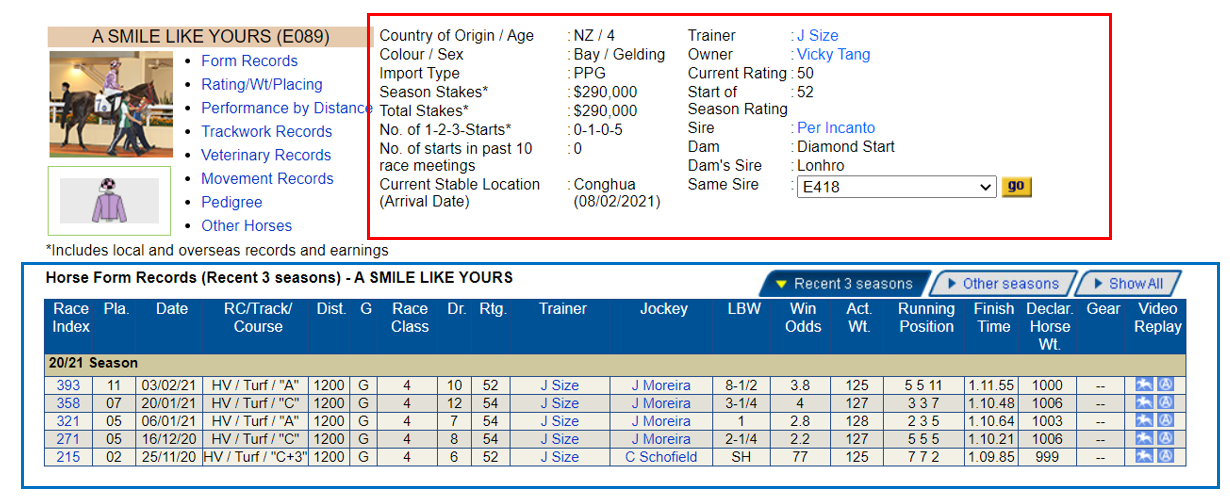

In [3]:
from IPython import display
display.Image("C:/Users/christy/Desktop/example.png")

# Data Scraping

In [ ]:
import requests
URL = 'https://racing.hkjc.com/racing/information/English/Racing/ResultsAll.aspx?RaceDate=2010/09/05'
page = requests.get('https://racing.hkjc.com/racing/information/chinese/Racing/ResultsAll.aspx?RaceDate=2010/09/05')

In [ ]:
# Solve the math game in the web page
from math import cos, pi, floor

import requests

def parse_challenge(page):
    """
    Parse a challenge given by mmi and mavat's web servers, forcing us to solve
    some math stuff and send the result as a header to actually get the page.
    This logic is pretty much copied from https://github.com/R3dy/jigsaw-rails/blob/master/lib/breakbot.rb
    """
    top = page.split('<script>')[1].split('\n')
    challenge = top[1].split(';')[0].split('=')[1]
    challenge_id = top[2].split(';')[0].split('=')[1]
    return {'challenge': challenge, 'challenge_id': challenge_id, 'challenge_result': get_challenge_answer(challenge)}


def get_challenge_answer(challenge):
    """
    Solve the math part of the challenge and get the result
    """
    arr = list(challenge)
    last_digit = int(arr[-1])
    arr.sort()
    min_digit = int(arr[0])
    subvar1 = (2 * int(arr[2])) + int(arr[1])
    subvar2 = str(2 * int(arr[2])) + arr[1]
    power = ((int(arr[0]) * 1) + 2) ** int(arr[1])
    x = (int(challenge) * 3 + subvar1)
    y = cos(pi * subvar1)
    answer = x * y
    answer -= power
    answer += (min_digit - last_digit)
    answer = str(int(floor(answer))) + subvar2
    return answer


def getPage(URL):
  if __name__ == '__main__':
    s = requests.Session()
    r = s.get(URL)

    if 'X-AA-Challenge' in r.text:
        challenge = parse_challenge(r.text)
        r = s.get(URL, headers={
            'X-AA-Challenge': challenge['challenge'],
            'X-AA-Challenge-ID': challenge['challenge_id'],
            'X-AA-Challenge-Result': challenge['challenge_result']
        })

        yum = r.cookies
        r = s.get(URL, cookies=yum)

    return r

In [ ]:
import requests, re
from bs4 import BeautifulSoup
from urllib.parse import urljoin

table_source = "https://racing.hkjc.com/racing/information/English/Horse/HorseFormerName.aspx"
start_url = "https://racing.hkjc.com"

page = getPage(table_source)

In [ ]:
# Extract the Link regarding the information of each horse
horse_info_links = []
soup = BeautifulSoup(page.text, 'html.parser')
table = BeautifulSoup(str(soup.find_all(class_='bigborder')))
links = table.find_all('a', href=re.compile("HorseId="))
for item in links:
    horse_info_links.append(urljoin(start_url, item['href']))
print(horse_info_links)
URL = horse_info_links[0]
name=URL.split("=")[1].split("_", 1)[1]
print(name)

In [ ]:
def horse_df(URL):
  name=URL.split("=")[1].split("_", 1)[1]
  page = getPage(URL)
  soup = BeautifulSoup(page.text, 'html.parser')
  table = soup.find_all(class_='bigborder')
  df = pd.read_html(str(table))

  df=df[0]
  df.columns=df.iloc[0]
  df=df.drop(0)
  df=df.drop(columns='VideoReplay')
  df['horse']=name

  df['season']=0
  for ind in range(len(df)):
    ind=ind+1
    if (df['G'][ind] == df['Dist.'][ind]):
      c = df['G'][ind][:5]
    df['season'][ind]=c
  df['N_RaceIndex']=df['season']+"_"+df['RaceIndex']

  for ind in range(len(df)):
    ind=ind+1
    if (df['G'][ind] == df['Dist.'][ind]):
      df['G'][ind]="NaN"
  indexNames = df[ df['G'] == "NaN" ].index
  df.drop(indexNames , inplace=True)
  return df

In [ ]:
# read tables of all horses using the hourses_id extracted eariler
df_list = []
import warnings
from time import time
warnings.filterwarnings("ignore")
start_time = time()
for link in horse_info_links:
    try:
        df = horse_df(link)
        df_list.append(df)
    except:
        continue
    print(f"Progress: {len(df_list)}/{len(horse_info_links)}")
    print(f"Time used: {time() - start_time}")
    print("=" * 20)

result = pd.concat(df_list)
result = result.reset_index(drop=True)


In [ ]:
result.to_csv("horse_info.csv")
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15017 entries, 0 to 15016
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   RaceIndex         15017 non-null  object
 1   Pla.              15017 non-null  object
 2   Date              15017 non-null  object
 3   RC/Track/Course   15017 non-null  object
 4   Dist.             15017 non-null  object
 5   G                 15017 non-null  object
 6   RaceClass         15017 non-null  object
 7   Dr.               15017 non-null  object
 8   Rtg.              15017 non-null  object
 9   Trainer           15017 non-null  object
 10  Jockey            15009 non-null  object
 11  LBW               15017 non-null  object
 12  Win Odds          15017 non-null  object
 13  Act.Wt.           15017 non-null  object
 14  RunningPosition   15017 non-null  object
 15  Finish Time       15017 non-null  object
 16  Declar.Horse Wt.  15017 non-null  object
 17  Gear        

# Data Preprocessing

## Load horse_info

In [ ]:
### Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')
### Load data from drive
horse_info = pd.read_csv("drive/MyDrive/COMP3359 Project/horse_info.csv")
horse_info

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,0,RaceIndex,Pla.,Date,RC/Track/Course,Dist.,G,RaceClass,Dr.,Rtg.,Trainer,Jockey,LBW,Win Odds,Act.Wt.,RunningPosition,Finish Time,Declar.Horse Wt.,Gear,horse,season,N_RaceIndex
0,0,452,11,24/2/2021,"HV / Turf / ""C+3""",1650,GF,4,10,60,L Ho,H T Mo,13/1/2002,150,130,2 2 2 11,1.42.71,1217,B/TT-,2019_D466,20/21,20/21_452
1,1,334,14,10/1/2021,"ST / Turf / ""C""",1600,G,3,14,64,L Ho,C Wong,21/1/2002,396,112,3 2 11 14,1.37.64,1222,B1/TT,2019_D466,20/21,20/21_334
2,2,263,12,13/12/2020,"ST / Turf / ""A""",1400,G,3,9,67,L Ho,H T Mo,9/3/2004,346,118,14 13 13 12,1.23.18,1238,TT1,2019_D466,20/21,20/21_263
3,3,192,14,14/11/2020,"ST / Turf / ""C+3""",1400,G,3,7,70,L Ho,H T Mo,9,320,115,11 10 12 14,1.22.99,1253,--,2019_D466,20/21,20/21_192
4,4,120,12,18/10/2020,"ST / Turf / ""B+2""",1400,GF,3,9,72,L Ho,H T Mo,6,163,125,12 9 7 12,1.23.02,1223,--,2019_D466,20/21,20/21_120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15012,15012,117,13,21/10/2018,"ST / Turf / ""A""",1200,GF,3,7,72,W Y So,C Murray,7/3/2004,252,125,12 13 13,1.10.45,1060,H1/TT1,2017_B406,18/19,18/19_117
15013,15013,542,3,28/3/2021,"ST / Turf / ""A+3""",1400,GF,4,7,59,J Size,B Shinn,3,4.8,132,12 10 5 3,1.21.62,1031,H/P/TT,2019_D415,20/21,20/21_542
15014,15014,463,1,28/2/2021,"ST / Turf / ""B+2""",1400,G,4,2,53,J Size,B Shinn,1/1/2004,5.3,128,9 7 6 1,1.22.13,1028,H/P/TT,2019_D415,20/21,20/21_463
15015,15015,390,6,31/1/2021,"ST / Turf / ""B+2""",1400,G,4,9,53,J Size,A Badel,2,13,127,11 12 13 6,1.22.53,1042,H/P/TT,2019_D415,20/21,20/21_390


We drop features that cannot be obtained before the game, like "running position", "LBW" refering the difference in distance of the horse with the winning horse. Some of the non-numeric data like Gear is converted to number of gear.

In [ ]:
# We define a function to do basic preprocessing for data exploration

def time_map(org_time):
    splited_time = org_time.split(".")
    calculated_time = int(splited_time[0])*60*100 + int(splited_time[1])*100 + int(splited_time[2])
    return calculated_time

def horse_info_preprocess(df):
    df['RC'] = df['RC/Track/Course'].str.split("/", expand=True)[0]
    df['Track'] = df['RC/Track/Course'].str.split("/", expand=True)[1]
    df['Course'] = df['RC/Track/Course'].str.split("/", expand=True)[2]
    df.drop(["0","RaceIndex", "RunningPosition", "RC/Track/Course", "Date", "LBW","season"], axis=1, inplace=True)
    
    #df.drop(["Pla.","N_RaceIndex"], axis=1, inplace=True)
    
    df.replace("--", np.NaN, inplace=True)
    df = df[df['Finish Time'].notna()]
    df["Gear"].fillna("None")
    df['NoofGear']=0
    for ind in df.index:
      if (df['Gear'][ind]!='NaN'):
        try:
          df['NoofGear'][ind]=len(df['Gear'][ind])
        except:
          continue

    df[["Win Odds", "Declar.Horse Wt.","Rtg.","Dr."]] = df[["Win Odds", "Declar.Horse Wt.","Rtg.","Dr."]].apply(pd.to_numeric)
    
    df["Finish Time"] = df["Finish Time"].map(time_map)

    return df

In [ ]:
horse_info_processed1=horse_info_preprocess(horse_info)

In [ ]:
horse_info_processed1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14794 entries, 0 to 15016
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pla.              14794 non-null  object 
 1   Dist.             14794 non-null  int64  
 2   G                 14794 non-null  object 
 3   RaceClass         14794 non-null  object 
 4   Dr.               14794 non-null  int64  
 5   Rtg.              14741 non-null  float64
 6   Trainer           14794 non-null  object 
 7   Jockey            14794 non-null  object 
 8   Win Odds          14782 non-null  float64
 9   Act.Wt.           14794 non-null  int64  
 10  Finish Time       14794 non-null  int64  
 11  Declar.Horse Wt.  14791 non-null  float64
 12  Gear              11509 non-null  object 
 13  horse             14794 non-null  object 
 14  N_RaceIndex       14794 non-null  object 
 15  RC                14794 non-null  object 
 16  Track             14794 non-null  object

In [ ]:
for i in horse_info_processed1.columns:
  try:
    print("------------",i,"------------")
    print(horse_info_processed1[i].describe())
  except:
    continue

------------ Pla. ------------
count     14794
unique       14
top           1
freq       1397
Name: Pla., dtype: object
------------ Dist. ------------
count    14794.000000
mean      1387.636880
std        272.285467
min       1000.000000
25%       1200.000000
50%       1400.000000
75%       1650.000000
max       2400.000000
Name: Dist., dtype: float64
------------ G ------------
count     14794
unique        7
top           G
freq       9568
Name: G, dtype: object
------------ RaceClass ------------
count     14794
unique       14
top           4
freq       6168
Name: RaceClass, dtype: object
------------ Dr. ------------
count    14794.000000
mean         6.788766
std          3.706013
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         14.000000
Name: Dr., dtype: float64
------------ Rtg. ------------
count    14741.000000
mean        61.677905
std         17.944159
min          7.000000
25%         50.000000
50%         60.000000
75

From the statistics, we want to investigate the distribution of the non-numeric features like "Trainer", "Jockey", "Gear", "Track", "G" and "RC"

### Distribution Chart

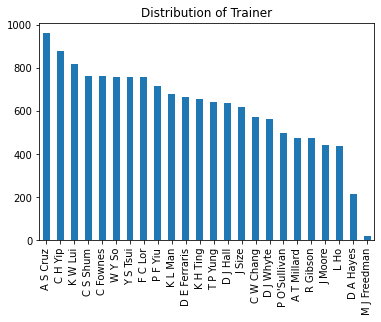

In [ ]:
horse_info_processed1["Trainer"].value_counts().plot(kind="bar",title="Distribution of Trainer")

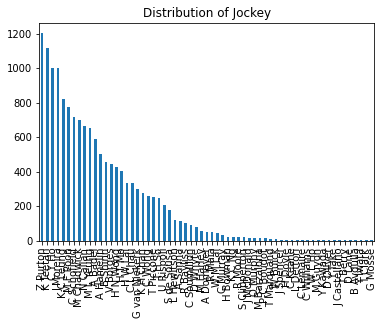

In [ ]:
horse_info_processed1["Jockey"].value_counts().plot(kind="bar",title="Distribution of Jockey")

We can see there are large number of unique trainer and jockey which make one-hot encoding impossible

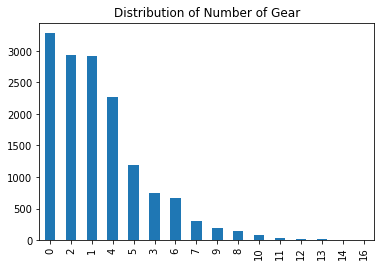

In [ ]:
horse_info_processed1["NoofGear"].value_counts().plot(kind="bar",title="Distribution of Number of Gear")

 Turf     13380
 AWT       1411
 Turf         2
 Sand         1
Name: Track, dtype: int64

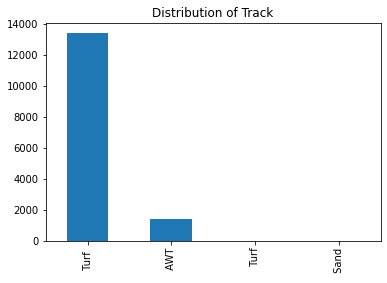

In [ ]:
horse_info_processed1["Track"].value_counts().plot(kind="bar",title="Distribution of Track")
horse_info_processed1["Track"].value_counts()

G     9568
GF    3521
GD    1180
WS     231
GY     194
Y       99
MY       1
Name: G, dtype: int64

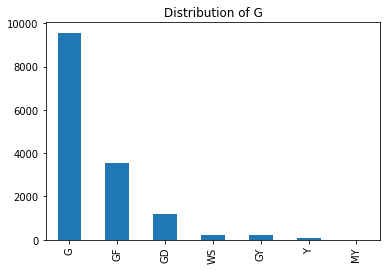

In [ ]:
horse_info_processed1["G"].value_counts().plot(kind="bar",title="Distribution of G")
horse_info_processed1["G"].value_counts()

ST         9451
HV         5328
CH           12
Kranji        2
Seoul         1
Name: RC, dtype: int64

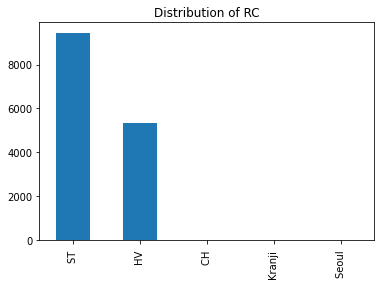

In [ ]:
horse_info_processed1["RC"].value_counts().plot(kind="bar",title="Distribution of RC")
horse_info_processed1["RC"].value_counts()

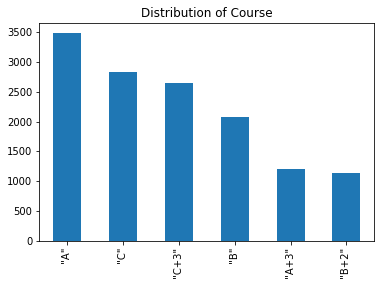

In [ ]:
horse_info_processed1["Course"].value_counts().plot(kind="bar",title="Distribution of Course")

4          6168
3          5250
2          1363
5          1327
1           156
G3          134
G1          133
4YO          88
G2           81
GRIFFIN      52
4R           30
R             9
SIN G1        2
KOR G1        1
Name: RaceClass, dtype: int64

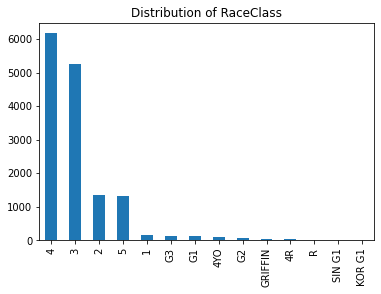

In [ ]:
horse_info_processed1["RaceClass"].value_counts().plot(kind="bar",title="Distribution of RaceClass")
horse_info_processed1["RaceClass"].value_counts()

The following preprocess will be carried out:

1. remove data which contains special entries, e.g {Kranji, Seoul} in 'RC', {'MY'} in 'G', {Turf, Sand} in 'Track',{'SIN G1','KOR G1','R'} in RaceClass
2. One hot encoding for the columns with reasonable number of options: ['G','RaceClass','RC','Track','Course']
3. Drop:['Trainer','Jockey']

In [ ]:
horse_info_processed1[horse_info_processed1.RC.str.contains('Kranji|Seoul')]

,Pla.,Dist.,G,RaceClass,Dr.,Rtg.,Trainer,Jockey,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,season,N_RaceIndex,RC,Track,Course,NoofGear
4837,4,1800,MY,KOR G1,1,94.0,F C Lor,C Y Ho,3.3,126,11450,NaN,NaN,2017_B210,19/20,19/20_Overseas,Seoul,Sand,None,0
10981,3,1600,G,SIN G1,10,118.0,A T Millard,K Teetan,3.8,126,9411,NaN,SR/XB,2017_B104,18/19,18/19_Overseas,Kranji,Turf,None,5
11445,1,1600,G,SIN G1,2,123.0,C Fownes,Z Purton,1.6,126,9361,NaN,XB-/V2,2016_A252,18/19,18/19_Overseas,Kranji,Turf,None,6


In [ ]:
horse_info_processed1[horse_info_processed1['RaceClass']=='R']

,Pla.,Dist.,G,RaceClass,Dr.,Rtg.,Trainer,Jockey,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,season,N_RaceIndex,RC,Track,Course,NoofGear
7355,4,1400,G,R,3,49.0,C H Yip,A Badel,26.0,120,8324,1087.0,TT,2018_C419,19/20,19/20_284,ST,Turf,"""B+2""",2
7386,2,1400,G,R,4,51.0,K L Man,S de Sousa,11.0,120,8287,1078.0,NaN,2018_C437,19/20,19/20_284,ST,Turf,"""B+2""",0
8012,6,1400,G,R,7,54.0,C Fownes,C Y Ho,3.9,120,8359,1090.0,NaN,2019_D050,19/20,19/20_284,ST,Turf,"""B+2""",0
8846,3,1400,G,R,1,52.0,C H Yip,D Whyte,129.0,120,8293,1046.0,NaN,2017_B426,18/19,18/19_275,ST,Turf,"""A+3""",0
9086,1,1200,G,R,2,64.0,R Gibson,M Chadwick,NaN,122,6928,1068.0,H-/B,2017_B371,18/19,18/19_515,CH,Turf,"""A""",4
9089,6,1400,G,R,8,62.0,R Gibson,M Chadwick,11.0,122,8307,1087.0,B/H,2017_B371,18/19,18/19_275,ST,Turf,"""A+3""",3
9879,2,1400,G,R,5,53.0,D J Hall,C Schofield,24.0,120,8287,1071.0,NaN,2017_B250,18/19,18/19_275,ST,Turf,"""A+3""",0
10777,8,1400,G,R,2,56.0,R Gibson,A Badel,20.0,120,8400,1078.0,NaN,2018_C046,18/19,18/19_275,ST,Turf,"""A+3""",0
11131,2,1200,G,R,4,63.0,W Y So,A Sanna,NaN,125,6946,1155.0,B/TT,2016_A314,18/19,18/19_515,CH,Turf,"""A""",4


In [ ]:
#final preprocess on horse_info
def horse_info_final_preprocess(df):
    df=df[~df.RC.str.contains('Kranji|Seoul')]
    df=df[df.RaceClass!='R']
    df=pd.get_dummies(df,columns=['G','RaceClass','RC','Track','Course'])
    df.drop(["Trainer", "Jockey"], axis=1, inplace=True)

    return df

In [ ]:
horse_info_final=horse_info_final_preprocess(horse_info_processed1)

In [ ]:
horse_info_final

,Pla.,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,N_RaceIndex,NoofGear,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3"""
0,11,1650,10,60.0,150.0,130,10271,1217.0,B/TT-,2019_D466,20/21_452,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,14,1600,14,64.0,396.0,112,9764,1222.0,B1/TT,2019_D466,20/21_334,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,12,1400,9,67.0,346.0,118,8318,1238.0,TT1,2019_D466,20/21_263,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
3,14,1400,7,70.0,320.0,115,8299,1253.0,NaN,2019_D466,20/21_192,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
4,12,1400,9,72.0,163.0,125,8302,1223.0,NaN,2019_D466,20/21_120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15012,13,1200,7,72.0,252.0,125,7045,1060.0,H1/TT1,2017_B406,18/19_117,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
15013,3,1400,7,59.0,4.8,132,8162,1031.0,H/P/TT,2019_D415,20/21_542,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
15014,1,1400,2,53.0,5.3,128,8213,1028.0,H/P/TT,2019_D415,20/21_463,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
15015,6,1400,9,53.0,13.0,127,8253,1042.0,H/P/TT,2019_D415,20/21_390,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0


## Load horse_family

In [ ]:
horse_family = pd.read_csv("drive/MyDrive/COMP3359 Project/horse_family.csv")

In [ ]:
horse_family.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             1293 non-null   int64  
 1   Import Type                            1293 non-null   object 
 2   Season Stakes*                         1293 non-null   object 
 3   Total Stakes*                          1293 non-null   object 
 4   No. of 1-2-3-Starts*                   1293 non-null   object 
 5   No. of starts in past 10race meetings  1293 non-null   int64  
 6   PP Pre-import races footage            0 non-null      float64
 7   Current Stable Location(Arrival Date)  1293 non-null   object 
 8   Trainer                                1293 non-null   object 
 9   Owner                                  1293 non-null   object 
 10  Current Rating                         1234 non-null   float64
 11  Star

In [ ]:
horse_family.head()

,Unnamed: 0,Import Type,Season Stakes*,Total Stakes*,No. of 1-2-3-Starts*,No. of starts in past 10race meetings,PP Pre-import races footage,Current Stable Location(Arrival Date),Trainer,Owner,Current Rating,Start ofSeason Rating,Sire,Dam,Dam's Sire,Same Sire,Country of Origin,Age,Colour,Sex,name
0,0,PP,$0,$0,0-0-0-6,0,NaN,Hong Kong(08/06/2020),L Ho,Focuson Syndicate,60.0,72.0,O'Reilly,Music,Pins,BRIGHT VISION GOKO NUNCHUKS SACRED IBIS SHININ...,NZ,5,Bay,Gelding,2019_D466
1,1,PPG,"$570,000","$570,000",1-0-0-2,1,NaN,Conghua(25/03/2021),K H Ting,Nadine Lai,60.0,52.0,Denman,Red Magnum,Domesday,E416 CHAMPION SUPREME DR PROACTIVE GOLDEN FOUR...,AUS,3,Bay,Gelding,2020_E147
2,2,PPG,"$290,000","$290,000",0-1-0-5,0,NaN,Conghua(08/02/2021),J Size,Vicky Tang,50.0,52.0,Per Incanto,Diamond Start,Lonhro,E418 CHARITY GRACE CLASSIC UNICORN DAZZLING FE...,NZ,4,Bay,Gelding,2020_E089
3,3,PP,$0,$0,0-0-0-0,0,NaN,Conghua(04/03/2021),D A Hayes,"Charmaine Li Chi Yin, Adrian Li Kwok Sheung & ...",75.0,75.0,Dream Ahead,Maxi Dress,Shamardal,DIONYSUS COLLIN FABULOUS EIGHT SKY SPRINTER SU...,AUS,3,Bay,Gelding,2020_E202
4,4,PPG,"$1,270,000","$4,000,540",5-3-3-32,2,NaN,Hong Kong(23/07/2020),A T Millard,Mr & Mrs Paul Kan Man Lok,67.0,65.0,Tavistock,Once More,Thorn Park,BELUGA BUNDLE OF DELIGHT CELESTIAL VINTAGE CIN...,NZ,5,Bay,Gelding,2017_B345


### Chart and Statistics

In [ ]:
for i in horse_family.columns:
  try:
    print("------------",i,"------------")
    print(horse_family[i].describe())
  except:
    continue

------------ Unnamed: 0 ------------
count    1293.000000
mean      646.000000
std       373.401259
min         0.000000
25%       323.000000
50%       646.000000
75%       969.000000
max      1292.000000
Name: Unnamed: 0, dtype: float64
------------ Import Type ------------
count     1293
unique       3
top        PPG
freq       713
Name: Import Type, dtype: object
------------ Season Stakes* ------------
count     1293
unique     438
top         $0
freq       512
Name: Season Stakes*, dtype: object
------------ Total Stakes* ------------
count     1293
unique     732
top         $0
freq       435
Name: Total Stakes*, dtype: object
------------ No. of 1-2-3-Starts* ------------
count        1293
unique        666
top       0-0-0-0
freq          223
Name: No. of 1-2-3-Starts*, dtype: object
------------ No. of starts in past 10race meetings ------------
count    1293.000000
mean        0.887858
std         0.824705
min         0.000000
25%         0.000000
50%         1.000000
75%     

PPG    713
PP     508
ISG     72
Name: Import Type, dtype: int64

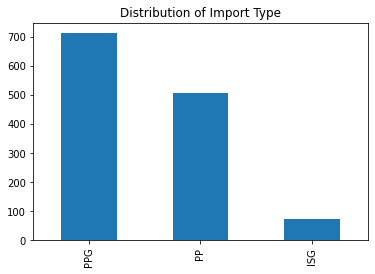

In [ ]:
horse_family["Import Type"].value_counts().plot(kind="bar",title="Distribution of Import Type")
horse_family["Import Type"].value_counts()

AUS     646
NZ      330
IRE     156
GB       67
SAF      33
FR       25
USA      15
GER       7
JPN       4
BRZ       4
CHI       2
ARG       2
ITY       2
Name: Country of Origin, dtype: int64

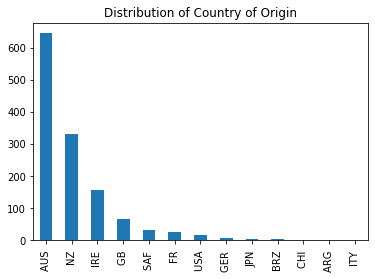

In [ ]:
horse_family["Country of Origin"].value_counts().plot(kind="bar",title="Distribution of Country of Origin")
horse_family["Country of Origin"].value_counts()

Bay          850
Chestnut     210
Brown        169
Grey          50
Dark Bay       9
Black          5
Name: Colour, dtype: int64

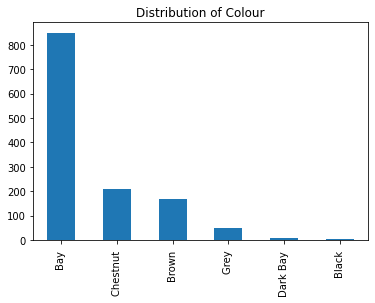

In [ ]:
horse_family["Colour"].value_counts().plot(kind="bar",title="Distribution of Colour")
horse_family["Colour"].value_counts()

 Gelding    1219
 Colt         32
 Brown        27
 Grey          5
 Horse         4
 Rig           3
 Roan          2
 Filly         1
Name: Sex, dtype: int64

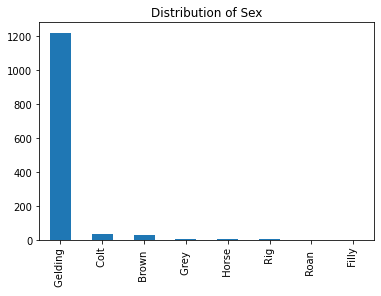

In [ ]:
horse_family["Sex"].value_counts().plot(kind="bar",title="Distribution of Sex")
horse_family["Sex"].value_counts()

In [ ]:
horse_family["Dam"].value_counts()

Savabeel Star         3
Extension Of Time     3
Princess Annaliese    2
Steps In Time         2
Diademe               2
                     ..
Negotiate             1
Queen Of Quilts       1
Anne Of Cleves        1
Princess Paris        1
Angelic Air           1
Name: Dam, Length: 1261, dtype: int64

In [ ]:
horse_family["No. of starts in past 10race meetings"].value_counts()

0    497
1    467
2    306
3     23
Name: No. of starts in past 10race meetings, dtype: int64

["Import Type", "Current Stable Location", "Trainer","Owner","Same Sire"," PP Pre-import races footage","Start of Season Rating" ]: drop

In [ ]:
def horse_family_preprocess(df):
    try:
        df.drop(["Unnamed: 0", "PP Pre-import races footage", "Current Stable Location(Arrival Date)", "Owner", "Same Sire", "Current Rating", "Start ofSeason Rating", "Trainer"], axis=1, inplace=True)
    except:
        pass    

    df[['First','Second','Third','Total']] = df['No. of 1-2-3-Starts*'].str.split('-', expand=True)
    df["top 3%"]=(df["First"].astype(int)+df["Second"].astype(int)+df["Third"].astype(int))/df["Total"].astype(int)
    df["top 3%"] = df["top 3%"].fillna(0)

    df["Season Stakes*"] = df["Season Stakes*"].str.split("$", expand=True)[1]
    df["Season Stakes*"] = df["Season Stakes*"].replace(',','', regex=True)
    df["Season Stakes*"] = df["Season Stakes*"].astype(float)

    df["Total Stakes*"] = df["Total Stakes*"].str.split("$", expand=True)[1]
    df["Total Stakes*"] = df["Total Stakes*"].replace(',','', regex=True)
    df["Total Stakes*"] = df["Total Stakes*"].astype(float)

    return df

In [ ]:
horse_family_processed1=horse_family_preprocess(horse_family)
horse_family_processed1

,Import Type,Season Stakes*,Total Stakes*,No. of 1-2-3-Starts*,No. of starts in past 10race meetings,Sire,Dam,Dam's Sire,Country of Origin,Age,Colour,Sex,name,First,Second,Third,Total,top 3%
0,PP,0.0,0.0,0-0-0-6,0,O'Reilly,Music,Pins,NZ,5,Bay,Gelding,2019_D466,0,0,0,6,0.000000
1,PPG,570000.0,570000.0,1-0-0-2,1,Denman,Red Magnum,Domesday,AUS,3,Bay,Gelding,2020_E147,1,0,0,2,0.500000
2,PPG,290000.0,290000.0,0-1-0-5,0,Per Incanto,Diamond Start,Lonhro,NZ,4,Bay,Gelding,2020_E089,0,1,0,5,0.200000
3,PP,0.0,0.0,0-0-0-0,0,Dream Ahead,Maxi Dress,Shamardal,AUS,3,Bay,Gelding,2020_E202,0,0,0,0,0.000000
4,PPG,1270000.0,4000540.0,5-3-3-32,2,Tavistock,Once More,Thorn Park,NZ,5,Bay,Gelding,2017_B345,5,3,3,32,0.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,PPG,0.0,0.0,0-0-0-0,0,Teofilo,Yes Oh Yes,Gone West,IRE,4,Bay,Gelding,2019_D462,0,0,0,0,0.000000
1289,PPG,35000.0,35000.0,0-0-0-5,3,Albrecht,Snaffles,Librettist,AUS,4,Bay,Gelding,2020_E078,0,0,0,5,0.000000
1290,PPG,0.0,0.0,0-0-0-1,1,The Factor,Dollars Not Sense,Onemorenomore,AUS,3,Grey,Gelding,2020_E186,0,0,0,1,0.000000
1291,PP,650000.0,2307935.0,1-4-3-29,1,Big Bad Bob,Rupa,Acclamation,IRE,6,Brown,Gelding,2017_B406,1,4,3,29,0.275862


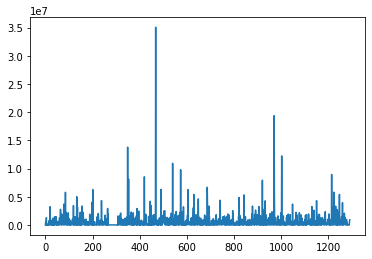

In [ ]:
horse_family_processed1["Season Stakes*"].plot()

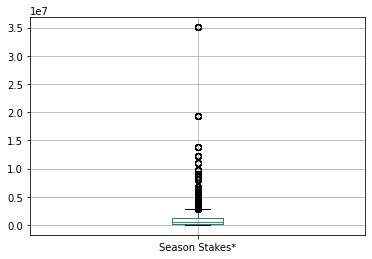

In [ ]:
figure=horse_family_processed1.boxplot(column="Season Stakes*")

In [ ]:
horse_family_processed1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Import Type                            1293 non-null   object 
 1   Season Stakes*                         1293 non-null   float64
 2   Total Stakes*                          1293 non-null   float64
 3   No. of 1-2-3-Starts*                   1293 non-null   object 
 4   No. of starts in past 10race meetings  1293 non-null   int64  
 5   Sire                                   1293 non-null   object 
 6   Dam                                    1293 non-null   object 
 7   Dam's Sire                             1293 non-null   object 
 8   Country of Origin                      1293 non-null   object 
 9   Age                                    1293 non-null   int64  
 10  Colour                                 1293 non-null   object 
 11  Sex 

In [ ]:
#final preprocess on horse_info
def horse_family_final_preprocess(df):
    df.drop(["Import Type","Total Stakes*","No. of 1-2-3-Starts*","No. of starts in past 10race meetings","Sire","Dam","Dam's Sire","First","Second","Third","Total","top 3%"], axis=1, inplace=True)
    df=pd.get_dummies(df,columns=['Country of Origin','Colour','Sex'])
    return df

In [ ]:
horse_family_final=horse_family_final_preprocess(horse_family_processed1)

In [ ]:
horse_family_final

,Season Stakes*,Age,name,Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,0.0,5,2019_D466,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,570000.0,3,2020_E147,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,290000.0,4,2020_E089,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.0,3,2020_E202,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1270000.0,5,2017_B345,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,0.0,4,2019_D462,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1289,35000.0,4,2020_E078,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1290,0.0,3,2020_E186,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1291,650000.0,6,2017_B406,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


## Merge two tables

In [ ]:
merged_table = pd.merge(horse_info_final, horse_family_final, how="inner", left_on="horse", right_on="name")
merged_table.drop(["name"], axis=1, inplace=True)

In [ ]:
merged_table

,Pla.,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,Gear,horse,N_RaceIndex,NoofGear,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Season Stakes*,Age,Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,11,1650,10,60.0,150.0,130,10271,1217.0,B/TT-,2019_D466,20/21_452,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,14,1600,14,64.0,396.0,112,9764,1222.0,B1/TT,2019_D466,20/21_334,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12,1400,9,67.0,346.0,118,8318,1238.0,TT1,2019_D466,20/21_263,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,14,1400,7,70.0,320.0,115,8299,1253.0,NaN,2019_D466,20/21_192,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,12,1400,9,72.0,163.0,125,8302,1223.0,NaN,2019_D466,20/21_120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,13,1200,7,72.0,252.0,125,7045,1060.0,H1/TT1,2017_B406,18/19_117,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,650000.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
14683,3,1400,7,59.0,4.8,132,8162,1031.0,H/P/TT,2019_D415,20/21_542,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14684,1,1400,2,53.0,5.3,128,8213,1028.0,H/P/TT,2019_D415,20/21_463,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14685,6,1400,9,53.0,13.0,127,8253,1042.0,H/P/TT,2019_D415,20/21_390,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


fill in the na value on age:

In [ ]:
merged_table.isnull().sum()

Pla.             0
Dist.            0
Dr.              0
Rtg.            53
Win Odds        10
                ..
Sex_ Gelding     0
Sex_ Grey        0
Sex_ Horse       0
Sex_ Rig         0
Sex_ Roan        0
Length: 69, dtype: int64

In [ ]:
#impute the rating and remove data without win odds
def merge_table_preprocessing(df):
  df = df[df['Win Odds'].notna()]
  df.drop(['Gear'], axis=1, inplace=True)
  for ind in df.index:
  #if rtg. is missing
    if (pd.isnull(df.loc[ind,'Rtg.'])==True):
      #if northern
      if (df['Country of Origin_GB '][ind]==1 or df['Country of Origin_IRE '][ind]==1 or df['Country of Origin_FR '][ind]==1 or df['Country of Origin_USA '][ind]==1 or df['Country of Origin_GER '][ind]==1 or df['Country of Origin_JPN '][ind]==1 or df['Country of Origin_ITY '][ind]==1):
        try:
          df['Rtg.'][ind]=57
        except:
          continue
      else:
        df['Rtg.'][ind]=52
  return df

In [ ]:
merged_final = merge_table_preprocessing(merged_table)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back

In [ ]:
merged_final

,Pla.,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Finish Time,Declar.Horse Wt.,horse,N_RaceIndex,NoofGear,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Season Stakes*,Age,Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,11,1650,10,60.0,150.0,130,10271,1217.0,2019_D466,20/21_452,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,14,1600,14,64.0,396.0,112,9764,1222.0,2019_D466,20/21_334,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12,1400,9,67.0,346.0,118,8318,1238.0,2019_D466,20/21_263,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,14,1400,7,70.0,320.0,115,8299,1253.0,2019_D466,20/21_192,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,12,1400,9,72.0,163.0,125,8302,1223.0,2019_D466,20/21_120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,13,1200,7,72.0,252.0,125,7045,1060.0,2017_B406,18/19_117,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,650000.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
14683,3,1400,7,59.0,4.8,132,8162,1031.0,2019_D415,20/21_542,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14684,1,1400,2,53.0,5.3,128,8213,1028.0,2019_D415,20/21_463,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14685,6,1400,9,53.0,13.0,127,8253,1042.0,2019_D415,20/21_390,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,905000.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


## Data Exploration and Normalization

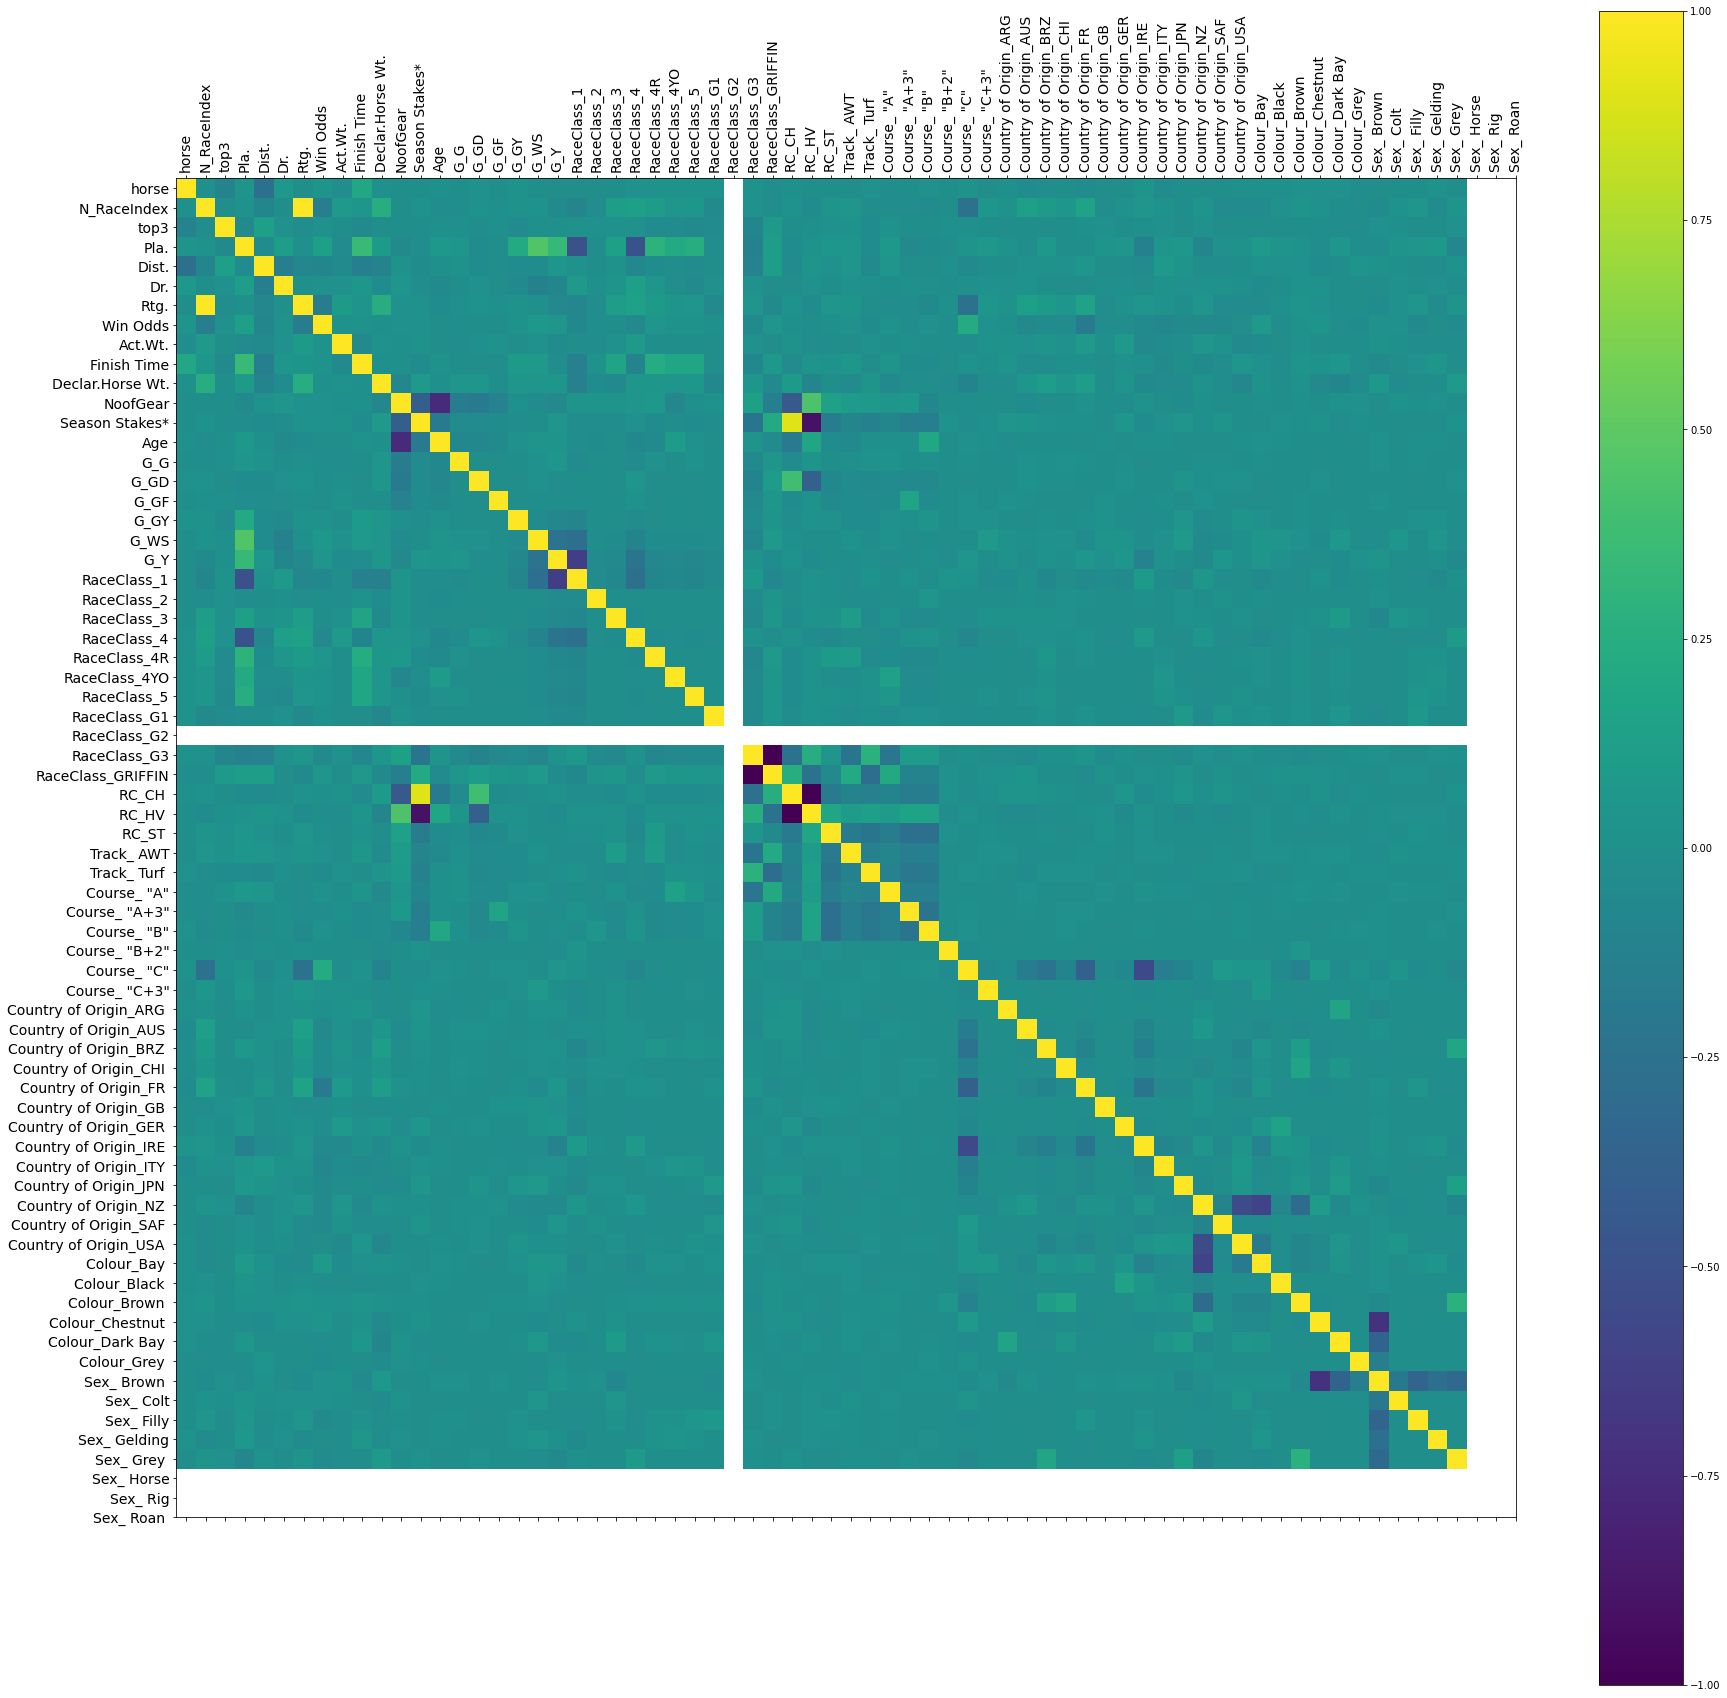

In [ ]:
import matplotlib.pyplot as plt

df=fdf

def phase_corrmat():
  f = plt.figure(figsize=(30,30))
  #df = test_df
  plt.matshow(df.corr(), fignum=f.number)
  plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
  plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
  plt.colorbar()
phase_corrmat()

In [ ]:
merged_final.columns

Index(['Pla.', 'Dist.', 'Dr.', 'Rtg.', 'Win Odds', 'Act.Wt.', 'Finish Time',
       'Declar.Horse Wt.', 'horse', 'N_RaceIndex', 'NoofGear', 'G_G', 'G_GD',
       'G_GF', 'G_GY', 'G_WS', 'G_Y', 'RaceClass_1', 'RaceClass_2',
       'RaceClass_3', 'RaceClass_4', 'RaceClass_4R', 'RaceClass_4YO',
       'RaceClass_5', 'RaceClass_G1', 'RaceClass_G2', 'RaceClass_G3',
       'RaceClass_GRIFFIN', 'RC_CH ', 'RC_HV ', 'RC_ST ', 'Track_ AWT',
       'Track_ Turf ', 'Course_ "A"', 'Course_ "A+3"', 'Course_ "B"',
       'Course_ "B+2"', 'Course_ "C"', 'Course_ "C+3"', 'Season Stakes*',
       'Age', 'Country of Origin_ARG ', 'Country of Origin_AUS ',
       'Country of Origin_BRZ ', 'Country of Origin_CHI ',
       'Country of Origin_FR ', 'Country of Origin_GB ',
       'Country of Origin_GER ', 'Country of Origin_IRE ',
       'Country of Origin_ITY ', 'Country of Origin_JPN ',
       'Country of Origin_NZ ', 'Country of Origin_SAF ',
       'Country of Origin_USA ', 'Colour_Bay ', 'Colour_Black '

In [ ]:
fdf=merged_final

def top_3(row):
  if int(row['Pla.'])<=3:
    return 1
  else:
    return 0

def top_1(row):
  if int(row['Pla.'])==1: return 1
  return 0

fdf['top3'] = fdf.apply(top_3, axis=1)
fdf['top1'] = fdf.apply(top_1, axis=1)

fdf=fdf[['horse','N_RaceIndex','top3','top1','Pla.','Finish Time','Dist.','Dr.','Rtg.','Win Odds', 'Act.Wt.',
       'Declar.Horse Wt.', 'NoofGear','Season Stakes*',
       'Age','G_G', 'G_GD','G_GF', 'G_GY', 'G_WS', 'G_Y', 'RaceClass_1', 'RaceClass_2',
       'RaceClass_3', 'RaceClass_4', 'RaceClass_4R', 'RaceClass_4YO',
       'RaceClass_5', 'RaceClass_G1', 'RaceClass_G2', 'RaceClass_G3',
       'RaceClass_GRIFFIN', 'RC_CH ', 'RC_HV ', 'RC_ST ', 'Track_ AWT',
       'Track_ Turf ', 'Course_ "A"', 'Course_ "A+3"', 'Course_ "B"',
       'Course_ "B+2"', 'Course_ "C"', 'Course_ "C+3"', 'Country of Origin_ARG ', 'Country of Origin_AUS ',
       'Country of Origin_BRZ ', 'Country of Origin_CHI ',
       'Country of Origin_FR ', 'Country of Origin_GB ',
       'Country of Origin_GER ', 'Country of Origin_IRE ',
       'Country of Origin_ITY ', 'Country of Origin_JPN ',
       'Country of Origin_NZ ', 'Country of Origin_SAF ',
       'Country of Origin_USA ', 'Colour_Bay ', 'Colour_Black ',
       'Colour_Brown ', 'Colour_Chestnut ', 'Colour_Dark Bay ', 'Colour_Grey ',
       'Sex_ Brown ', 'Sex_ Colt', 'Sex_ Filly', 'Sex_ Gelding', 'Sex_ Grey ',
       'Sex_ Horse', 'Sex_ Rig', 'Sex_ Roan ']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fdf

,horse,N_RaceIndex,top3,top1,Pla.,Finish Time,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Declar.Horse Wt.,NoofGear,Season Stakes*,Age,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,2019_D466,20/21_452,0,0,11,10271,1650,10,60.0,150.0,130,1217.0,5,0.0,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2019_D466,20/21_334,0,0,14,9764,1600,14,64.0,396.0,112,1222.0,5,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2019_D466,20/21_263,0,0,12,8318,1400,9,67.0,346.0,118,1238.0,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2019_D466,20/21_192,0,0,14,8299,1400,7,70.0,320.0,115,1253.0,0,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2019_D466,20/21_120,0,0,12,8302,1400,9,72.0,163.0,125,1223.0,0,0.0,5,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,2017_B406,18/19_117,0,0,13,7045,1200,7,72.0,252.0,125,1060.0,6,650000.0,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
14683,2019_D415,20/21_542,1,0,3,8162,1400,7,59.0,4.8,132,1031.0,6,905000.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14684,2019_D415,20/21_463,1,1,1,8213,1400,2,53.0,5.3,128,1028.0,6,905000.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14685,2019_D415,20/21_390,0,0,6,8253,1400,9,53.0,13.0,127,1042.0,6,905000.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
from google.colab import files
fdf.to_csv("full_data.csv", index=False)
files.download("full_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')
### Load data from drive
fdf = pd.read_csv("drive/MyDrive/COMP3359 Project/full_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
x_train = df_train.iloc[:,6:].values
y3_train = df_train["top3"]
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
x_test = df_test.iloc[:,6:].values
y3_test = df_test["top3"]
y1_test = df_test["top1"]

feature=df_train.columns[6:].values